# Alphavirus RdRp conservation Analysis

# Direct Coupling Analysis (DCA), direct information (DI)

Traditional covariance methods can identify correlated variables (like amino acid residues in proteins that change together) but can't differentiate if these correlations are direct (two variables directly influencing each other) or indirect (their correlation is due to both being influenced by a third variable).  

DCA goes beyond traditional covariance methods by attempting to infer direct interactions between variables (e.g., amino acid residues in a protein) from large multiple sequence alignments (MSAs). The output of DCA includes scores for pairs of positions in a sequence, indicating the strength and likelihood that they interact directly, rather than merely appearing to interact due to indirect effects mediated by other positions.  

### How DCA Works
**Multiple Sequence Alignment**: DCA begins with an MSA, which aligns sequences from similar proteins across different species or variants. This alignment helps identify conserved and variable positions across sequences.    

**Covariance Calculation**: DCA calculates the covariance for each pair of positions in the MSA. High covariance suggests that changes in one position often coincide with changes in another, which might indicate some form of interaction.    

**Inferring Direct Interactions**:
Unlike simpler covariance methods, DCA uses statistical models to differentiate direct interactions from indirect correlations.
The model assigns a score to each possible pair of residues, with higher scores indicating a stronger likelihood of direct interaction.   

**Inversion of the Covariance Matrix**: One approach within DCA involves inverting the covariance matrix of the alignment to extract direct information, which helps in separating direct from indirect interactions.

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO, AlignIO
from Bio.PDB import PDBParser, PDBIO, Chain

import ast


pd.set_option('display.max_columns', 110)

In [2]:
def Zscore(column_val):
    m = np.mean(column_val)
    std = np.std(column_val)
    zscore = [((x - m)/std) for x in column_val]
    return zscore

## Extended

In [3]:
## Load results
cov = pd.read_csv('results/alphavirus/DCA/mfdca_output_nsp4-RdRp-SAXS_extended_pdb_seq_Trimmed_alphavirus_rvdb_nsp4_concat_aligned_filter_nsp4_region_v03_unwrap.csv')

# converts tuple os string into a tuple of integers
cov['Tuple'] = [ast.literal_eval(i) for i in cov['Tuple']]
print(cov['APC'].mean(axis=0))

cov['Zscore'] = Zscore(cov['APC'])
cov.head()

0.00016590188744098727


,first_site,second_site,Tuple,APC,Zscore
0,374,515,"(374, 515)",6.962154,38.598655
1,74,253,"(74, 253)",6.538940,36.252275
2,13,111,"(13, 111)",6.494101,36.003677
3,101,146,"(101, 146)",5.914367,32.789514
4,459,460,"(459, 460)",5.892217,32.666713


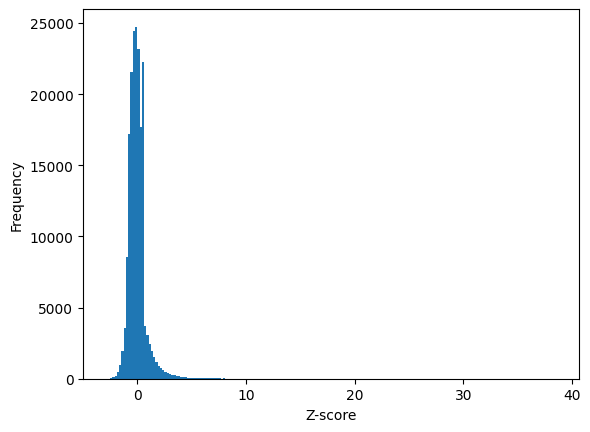

In [45]:
#cov[cov['Zscore'].between(-4,4)]['Zscore'].plot(kind='hist', bins=100)
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.savefig('results/alphavirus/DCA/mfdca_nsp4_extended_Zscore_hist.png')
plt.show()

In [35]:
counts, edges = np.histogram(cov['Zscore'], bins=500)

for i in range(len(counts)):
    if counts[i] >5000:
        print(f"Bin {i+1} ({edges[i]:.2f} to {edges[i+1]:.2f}): {counts[i]} values")


Bin 26 (-0.85 to -0.76): 5627 values
Bin 27 (-0.76 to -0.68): 7380 values
Bin 28 (-0.68 to -0.60): 8409 values
Bin 29 (-0.60 to -0.51): 8215 values
Bin 30 (-0.51 to -0.43): 9136 values
Bin 31 (-0.43 to -0.35): 9449 values
Bin 32 (-0.35 to -0.26): 9538 values
Bin 33 (-0.26 to -0.18): 11700 values
Bin 34 (-0.18 to -0.10): 9037 values
Bin 35 (-0.10 to -0.02): 9458 values
Bin 36 (-0.02 to 0.07): 9982 values
Bin 37 (0.07 to 0.15): 9267 values
Bin 38 (0.15 to 0.23): 8037 values
Bin 39 (0.23 to 0.32): 9214 values
Bin 41 (0.40 to 0.48): 19625 values


In [24]:
cov_ext_Nter = cov.query("first_site <100 or second_site < 100")
cov_ext_Nter

,first_site,second_site,Tuple,APC,Zscore
1,74,253,"(74, 253)",6.538940,36.252275
2,13,111,"(13, 111)",6.494101,36.003677
5,48,569,"(48, 569)",5.794249,32.123560
8,34,119,"(34, 119)",5.027475,27.872412
14,35,272,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...
186347,42,401,"(42, 401)",-0.473801,-2.627769
186348,76,171,"(76, 171)",-0.475852,-2.639136
186350,41,110,"(41, 110)",-0.487504,-2.703742
186351,42,43,"(42, 43)",-0.489327,-2.713845


In [3]:
neff = pd.read_excel('results/alphavirus/nsp4_alphavirus_urvdb_Full_Neff_.xlsx', index_col=0)
neff

,residueName,residueAbbrev,residue,Neff
0,TYR,Y,1,1.012403
1,ILE,I,2,1.022592
2,PHE,F,3,1.012403
3,SER,S,4,1.000000
4,SER,S,5,1.384145
...,...,...,...,...
606,TYR,Y,607,1.000000
607,GLY,G,608,1.052386
608,GLY,G,609,1.033411
609,PRO,P,610,1.000000


In [26]:
df1 = cov_ext_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_ext_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]]

#cov_ext_Nter_neff.query("Zscore > 3.0 & first_site_Neff > 3 & second_site_Neff > 3")
#cov_ext_Nter_neff = cov_ext_Nter_neff.query("APC > 1.0 & first_site_Neff > 3 & second_site_Neff > 3")
cov_ext_Nter_neff = cov_ext_Nter_neff.query("Zscore > 2.0")
cov_ext_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...,...,...,...,...
2045,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945
2046,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301
2047,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683
2048,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454


In [4]:
#cov_ext_Nter_neff.to_excel('results/alphavirus/DCA/nsp4_extended_contact_pairs_neff_APC_Zscore_Nter_zscore2.xlsx', index=False)
cov_ext_Nter_neff = pd.read_excel('results/alphavirus/DCA/nsp4_extended_contact_pairs_neff_APC_Zscore_Nter_zscore2.xlsx')
cov_ext_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...,...,...,...,...
2045,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945
2046,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301
2047,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683
2048,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454


In [7]:
extended_contact = pd.read_table('data/alphavirus/nsP4_pdb/nsp4-RdRp_extended_pairs_contact_v02.txt')
extended_contact 

,Contact,Residue1_Name,Residue1_Pos,Residue2_Name,Residue2_Pos,Pairs,Distance(Å)
0,1,TYR,1,TYR,1,"(1, 1)",0.00
1,2,TYR,1,ILE,2,"(1, 2)",3.83
2,3,TYR,1,PHE,3,"(1, 3)",6.21
3,4,TYR,1,SER,4,"(1, 4)",5.69
4,5,TYR,1,SER,5,"(1, 5)",5.75
...,...,...,...,...,...,...,...
60651,60652,ILE,100,TYR,607,"(100, 607)",58.53
60652,60653,ILE,100,GLY,608,"(100, 608)",58.84
60653,60654,ILE,100,GLY,609,"(100, 609)",61.57
60654,60655,ILE,100,PRO,610,"(100, 610)",65.11


In [8]:
cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_ext_Nter_neff.merge(extended_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275,41.78
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677,26.26
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560,75.36
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412,70.44
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486,44.85
...,...,...,...,...,...,...,...,...,...,...
2015,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945,43.42
2016,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301,96.57
2017,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683,85.52
2018,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454,67.95


In [9]:
df1= df[df['first_site'].between(20, 90) | df['second_site'].between(20, 90) ]
df2 = df1[abs(df1['first_site'] -  df1['second_site']) >= 4] 
df2 = df2.query('`Distance(Å)` < 10')
df2

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
55,LYS,39,4.107283,ASN,71,1.000000,"(39, 71)",2.213823,12.272957,8.66
147,LEU,88,2.009596,GLN,398,3.573938,"(88, 398)",1.429472,7.924360,8.06
457,ARG,51,1.761330,SER,55,6.039650,"(51, 55)",0.803592,4.454356,6.81
464,ARG,51,1.761330,ASN,60,1.000000,"(51, 60)",0.798954,4.428644,8.19
505,PRO,23,4.202011,PRO,103,1.116649,"(23, 103)",0.768633,4.260535,5.32
548,PRO,38,1.144242,ALA,74,1.158375,"(38, 74)",0.741047,4.107591,9.63
609,ASP,41,1.119340,ARG,67,1.170561,"(41, 67)",0.704477,3.904841,9.12
723,LEU,49,3.619874,ASN,60,1.000000,"(49, 60)",0.645730,3.579136,9.35
822,SER,55,6.039650,ASN,60,1.000000,"(55, 60)",0.599376,3.322142,7.62
838,ASP,41,1.119340,LEU,46,4.008090,"(41, 46)",0.594830,3.296938,9.45


In [10]:
extended_rASA = pd.read_excel('results/alphavirus/nsp4_rASA_extended.xlsx', index_col=0)
extended_rASA

,Residue,position,rASA
0,Y,1,0.555133
1,I,2,0.040609
2,F,3,0.216667
3,S,4,0.361290
4,S,5,0.154839
...,...,...,...
606,Y,607,0.250951
607,G,608,0.317308
608,G,609,0.346154
609,P,610,0.930818


In [11]:
mapping = {k:v for k, v in zip(extended_rASA['position'], extended_rASA['rASA'])}

In [12]:
df2['first_site_rASA'] = [mapping[x] for x in df2['first_site']]
df2['second_site_rASA'] = [mapping[x] for x in df2['second_site']]


cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_rASA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_rASA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ]

df2 = df2[cols]
df2

,first_site_residue,first_site,first_site_Neff,first_site_rASA,second_site_residue,second_site,second_site_Neff,second_site_rASA,Tuple,APC,Zscore,Distance(Å)
55,LYS,39,4.107283,0.355932,ASN,71,1.000000,0.010256,"(39, 71)",2.213823,12.272957,8.66
147,LEU,88,2.009596,0.328358,GLN,398,3.573938,0.355556,"(88, 398)",1.429472,7.924360,8.06
457,ARG,51,1.761330,0.405109,SER,55,6.039650,0.419355,"(51, 55)",0.803592,4.454356,6.81
464,ARG,51,1.761330,0.405109,ASN,60,1.000000,0.107692,"(51, 60)",0.798954,4.428644,8.19
505,PRO,23,4.202011,0.660377,PRO,103,1.116649,0.402516,"(23, 103)",0.768633,4.260535,5.32
548,PRO,38,1.144242,0.729560,ALA,74,1.158375,0.224806,"(38, 74)",0.741047,4.107591,9.63
609,ASP,41,1.119340,0.305699,ARG,67,1.170561,0.105839,"(41, 67)",0.704477,3.904841,9.12
723,LEU,49,3.619874,0.233831,ASN,60,1.000000,0.107692,"(49, 60)",0.645730,3.579136,9.35
822,SER,55,6.039650,0.419355,ASN,60,1.000000,0.107692,"(55, 60)",0.599376,3.322142,7.62
838,ASP,41,1.119340,0.305699,LEU,46,4.008090,0.391111,"(41, 46)",0.594830,3.296938,9.45


In [13]:
df2.shape

(20, 12)

In [14]:
#df2.to_excel('results/alphavirus/DCA/nsp4_extended_contact_pairs_neff_APC_Zscore_rASA_Nter_20_90_v02.xlsx', index=False)

## Contacts of SOI

In [4]:
ext_cont = pd.read_excel('results/alphavirus/nsp4_extended_SOI_neff.xlsx')
ext_cont = ext_cont[~ext_cont['nsp4'].isna()]
ext_cont['nsp4-Nter'].str.split('-').str[1]
ext_cont['contact_pairs'] = [x for x in zip(ext_cont['nsp4-Nter'].str.split('-').str[1].astype(int), ext_cont['nsp4'].str.split('-').str[1].astype(int))]
print(ext_cont.shape)
ext_cont

(30, 6)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,Interaction,contact_pairs
0,Thr-20,4.804889,Tyr-102,1.663264,bb-bb (Hb),"(20, 102)"
1,Asn-25,4.656432,Thr-101,4.159606,Sc-bb (Hb),"(25, 101)"
2,Tyr-36,1.551579,Cys-233,1.000000,Sc-bb (Hb),"(36, 233)"
3,Lys-39,4.107283,Glu-226,1.157364,Sc-Sc (Hb),"(39, 226)"
4,Lys-81,3.360074,Glu-392,1.012403,NaN,"(81, 392)"
5,Lys-81,3.360074,Asp-393,1.000000,Sc-Sc (Hb),"(81, 393)"
6,Cys-84,4.192845,Ala-242,2.673552,Sc-bb (Hb),"(84, 242)"
7,Arg-85,3.290797,Asp-397,1.158375,Sc-Sc (Hb),"(85, 397)"
8,Ser-90,3.642532,Asp-91,2.664443,Sc-bb (Hb),"(90, 91)"
9,Thr-21,5.725334,Pro-103,1.116649,Sc-Sc,"(21, 103)"


In [5]:
pairs = list(ext_cont['contact_pairs'].values)
res = cov.query('Tuple in @pairs')
print(res.shape)
res

(30, 5)


,first_site,second_site,Tuple,APC,Zscore
518,81,393,"(81, 393)",1.121309,6.215841
927,38,230,"(38, 230)",0.850403,4.713882
1065,29,98,"(29, 98)",0.794507,4.403987
1079,76,239,"(76, 239)",0.790765,4.383240
1844,90,91,"(90, 91)",0.615855,3.413502
4790,77,238,"(77, 238)",0.370998,2.055969
7464,25,101,"(25, 101)",0.280921,1.556562
7664,39,226,"(39, 226)",0.276368,1.531318
7808,76,242,"(76, 242)",0.272573,1.510281
12328,20,102,"(20, 102)",0.190213,1.053660


In [6]:
cols = ['first_site', 'second_site', 'Tuple']
df = ext_cont.merge(res, how='inner', left_on='contact_pairs', right_on='Tuple').drop(cols, axis=1).sort_values('APC', ascending=False)
print(df.shape)
df

(30, 8)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,Interaction,contact_pairs,APC,Zscore
5,Lys-81,3.360074,Asp-393,1.000000,Sc-Sc (Hb),"(81, 393)",1.121309,6.215841
21,Pro-38,1.144242,Lys-230,1.285854,Sc-Sc,"(38, 230)",0.850403,4.713882
13,Glu-29,3.431639,Tyr-98,1.251589,Sc-Sc (Hb),"(29, 98)",0.794507,4.403987
24,Ile-76,2.320685,Arg-239,3.419841,NaN,"(76, 239)",0.790765,4.383240
8,Ser-90,3.642532,Asp-91,2.664443,Sc-bb (Hb),"(90, 91)",0.615855,3.413502
26,Ile-77,3.586551,Trp-238,1.000000,Sc-Sc,"(77, 238)",0.370998,2.055969
1,Asn-25,4.656432,Thr-101,4.159606,Sc-bb (Hb),"(25, 101)",0.280921,1.556562
3,Lys-39,4.107283,Glu-226,1.157364,Sc-Sc (Hb),"(39, 226)",0.276368,1.531318
25,Ile-76,2.320685,Ala-242,2.673552,Sc-Sc,"(76, 242)",0.272573,1.510281
0,Thr-20,4.804889,Tyr-102,1.663264,bb-bb (Hb),"(20, 102)",0.190213,1.053660


In [7]:
#df.to_excel('results/alphavirus/DCA/nsp4_extended_contact_pairs_neff_APC_Zscore.xlsx', index=False)

In [117]:
apc = 2
total = cov.query("APC > @apc").shape[0]
query = cov.query("first_site <150 and APC > @apc").shape[0]
print(f"Total of sites with APC > {apc} in the first 150 sites: {total}")
print(f'Percentage of sites with APC > {apc} in the first 150 sites: {(query*100)/total:.2f}%')

#set(cov.query("first_site <150 and APC > @apc")['first_site'].values)

Total of sites with APC > 2 in the first 150 sites: 144
Percentage of sites with APC > 2 in the first 150 sites: 71.53%


In [ ]:
n = 100

data = cov.head(n)

fc=data['first_site'].unique()
sc=data['second_site'].unique()

correlation_matrix = np.zeros((len(fc), len(sc)))
print(correlation_matrix.shape)

#convert to a dataframe
correlation_matrix = pd.DataFrame(correlation_matrix, index=fc, columns=sc,)

#populate the matrix
for i, row in data.iterrows():
    i, j, v = row["first_site"], row['second_site'], row['APC']
    if i in fc and j in sc:
        correlation_matrix.loc[i,j] = v

correlation_matrix

In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Direct Coupling Analysis (mfDCA) - APC > 2', size=16)
sns.heatmap(correlation_matrix, cmap='rocket_r', cbar_kws={'label': 'DI Score (APC)'})
plt.ylabel("First Residue", size=12)
plt.xlabel("Second Residue", size=12)
#plt.xticks(rotation=0)
#plt.savefig('results/alphavirus/mfdca_heatmap_nsp4_extended.png')
plt.show()

## Compact structure

In [46]:
import ast

cov = pd.read_csv('results/alphavirus/DCA/mfdca_output_nsp4-RdRp_compact_pdb_seq_Trimmed_alphavirus_rvdb_nsp4_concat_aligned_filter_nsp4_region_v03_unwrap.csv')
print(cov['APC'].mean(axis=0))

cov['Zscore'] = Zscore(cov['APC'])
# converts tuple os string into a tuple of integers
cov['Tuple'] = [ast.literal_eval(i) for i in cov['Tuple']]
cov.head()

0.00016590188744098727


,first_site,second_site,Tuple,APC,Zscore
0,374,515,"(374, 515)",6.962154,38.598655
1,74,253,"(74, 253)",6.538940,36.252275
2,13,111,"(13, 111)",6.494101,36.003677
3,101,146,"(101, 146)",5.914367,32.789514
4,459,460,"(459, 460)",5.892217,32.666713


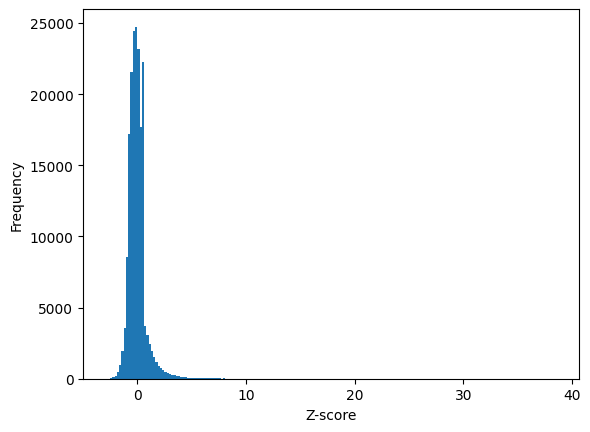

In [48]:
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.savefig('results/alphavirus/DCA/mfdca_nsp4_compact_Zscore_hist.png')
plt.show()

In [30]:
cov_comp_Nter = cov.query("first_site <100 or second_site < 100")
cov_comp_Nter

,first_site,second_site,Tuple,APC,Zscore
1,74,253,"(74, 253)",6.538940,36.252275
2,13,111,"(13, 111)",6.494101,36.003677
5,48,569,"(48, 569)",5.794249,32.123560
8,34,119,"(34, 119)",5.027475,27.872412
14,35,272,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...
186347,42,401,"(42, 401)",-0.473801,-2.627769
186348,76,171,"(76, 171)",-0.475852,-2.639136
186350,41,110,"(41, 110)",-0.487504,-2.703742
186351,42,43,"(42, 43)",-0.489327,-2.713845


In [44]:

neff = pd.read_excel('results/alphavirus/nsp4_alphavirus_urvdb_Full_Neff_.xlsx', index_col=0)

df1 = cov_comp_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_comp_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]]

#cov_comp_Nter_neff.query("Zscore > 3.0 & first_site_Neff > 3 & second_site_Neff > 3")
#cov_comp_Nter_neff = cov_comp_Nter_neff.query("APC > 1.0 & first_site_Neff > 3 & second_site_Neff > 3")
cov_comp_Nter_neff = cov_comp_Nter_neff.query("Zscore > 2.0")
cov_comp_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...,...,...,...,...
2045,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945
2046,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301
2047,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683
2048,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454


### Adding distance in Å

In [15]:
#cov_comp_Nter_neff.to_excel('results/alphavirus/DCA/nsp4_compact_contact_pairs_neff_APC_Zscore_Nter_zscore2.xlsx', index=False)
cov_comp_Nter_neff = pd.read_excel('results/alphavirus/DCA/nsp4_compact_contact_pairs_neff_APC_Zscore_Nter_zscore2.xlsx')
cov_comp_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486
...,...,...,...,...,...,...,...,...,...
2045,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945
2046,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301
2047,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683
2048,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454


In [16]:
compact_contact = pd.read_table('data/alphavirus/nsP4_pdb/nsp4-RdRp_compact_pairs_contact_v02.txt')
compact_contact 

,Contact,Residue1_Name,Residue1_Pos,Residue2_Name,Residue2_Pos,Pairs,Distance(Å)
0,1,TYR,1,TYR,1,"(1, 1)",0.00
1,2,TYR,1,ILE,2,"(1, 2)",3.84
2,3,TYR,1,PHE,3,"(1, 3)",5.81
3,4,TYR,1,SER,4,"(1, 4)",5.35
4,5,TYR,1,SER,5,"(1, 5)",5.94
...,...,...,...,...,...,...,...
61095,61096,ILE,100,TYR,607,"(100, 607)",60.02
61096,61097,ILE,100,GLY,608,"(100, 608)",60.80
61097,61098,ILE,100,GLY,609,"(100, 609)",63.66
61098,61099,ILE,100,PRO,610,"(100, 610)",67.34


In [17]:
cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_comp_Nter_neff.merge(compact_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",6.538940,36.252275,11.09
1,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",6.494101,36.003677,24.14
2,LEU,48,1.172680,ALA,569,1.045682,"(48, 569)",5.794249,32.123560,58.01
3,LYS,34,3.089355,GLU,119,3.741583,"(34, 119)",5.027475,27.872412,52.18
4,CYS,35,6.650522,THR,272,1.170561,"(35, 272)",4.567188,25.320486,22.74
...,...,...,...,...,...,...,...,...,...,...
2030,ASP,6,1.656967,SER,243,6.338598,"(6, 243)",0.361254,2.001945,44.40
2031,GLN,53,1.035269,ASN,126,1.048101,"(53, 126)",0.361138,2.001301,52.20
2032,ASP,41,1.119340,LEU,115,2.625704,"(41, 115)",0.361026,2.000683,54.82
2033,GLU,33,1.259029,TYR,148,1.000000,"(33, 148)",0.360985,2.000454,55.33


In [18]:
df1= df[df['first_site'].between(20, 90) | df['second_site'].between(20, 90) ]
df2 = df1[abs(df1['first_site'] -  df1['second_site']) >= 4] 
df2 = df2.query('`Distance(Å)` < 10')
df2

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
50,THR,20,4.804889,VAL,25,4.656432,"(20, 25)",2.366233,13.117953,7.70
55,LYS,39,4.107283,ASN,71,1.000000,"(39, 71)",2.213823,12.272957,6.86
137,VAL,30,5.015656,ILE,100,4.070730,"(30, 100)",1.492494,8.273764,9.43
165,CYS,84,4.192845,GLN,279,2.041886,"(84, 279)",1.341599,7.437171,7.98
186,LEU,80,1.515866,ALA,321,1.012403,"(80, 321)",1.287104,7.135041,9.75
289,ILE,76,2.320685,LEU,268,1.151631,"(76, 268)",1.032724,5.724707,7.77
311,PRO,23,4.202011,PRO,105,1.105974,"(23, 105)",0.999556,5.540821,9.22
458,ARG,51,1.761330,SER,55,6.039650,"(51, 55)",0.803592,4.454356,6.93
465,ARG,51,1.761330,ASN,60,1.000000,"(51, 60)",0.798954,4.428644,7.06
470,GLU,29,3.431639,TYR,98,1.251589,"(29, 98)",0.794507,4.403987,4.43


### Adding rASA

In [19]:
compact_rASA = pd.read_excel('results/alphavirus/nsp4_rASA_compact.xlsx', index_col=0)
compact_rASA

,Residue,position,rASA
0,Y,1,0.638783
1,I,2,0.233503
2,F,3,0.258333
3,S,4,0.212903
4,S,5,0.180645
...,...,...,...
606,Y,607,0.334601
607,G,608,0.259615
608,G,609,0.423077
609,P,610,0.911950


In [20]:
mapping = {k:v for k, v in zip(compact_rASA['position'], compact_rASA['rASA'])}

In [21]:
df2['first_site_rASA'] = [mapping[x] for x in df2['first_site']]
df2['second_site_rASA'] = [mapping[x] for x in df2['second_site']]


cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_rASA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_rASA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ]

df2 = df2[cols]
df2

,first_site_residue,first_site,first_site_Neff,first_site_rASA,second_site_residue,second_site,second_site_Neff,second_site_rASA,Tuple,APC,Zscore,Distance(Å)
50,THR,20,4.804889,0.174419,VAL,25,4.656432,0.517241,"(20, 25)",2.366233,13.117953,7.70
55,LYS,39,4.107283,0.601695,ASN,71,1.000000,0.010256,"(39, 71)",2.213823,12.272957,6.86
137,VAL,30,5.015656,0.080460,ILE,100,4.070730,0.294416,"(30, 100)",1.492494,8.273764,9.43
165,CYS,84,4.192845,0.017964,GLN,279,2.041886,0.391111,"(84, 279)",1.341599,7.437171,7.98
186,LEU,80,1.515866,0.114428,ALA,321,1.012403,0.232558,"(80, 321)",1.287104,7.135041,9.75
289,ILE,76,2.320685,0.005076,LEU,268,1.151631,0.283582,"(76, 268)",1.032724,5.724707,7.77
311,PRO,23,4.202011,0.748428,PRO,105,1.105974,0.176101,"(23, 105)",0.999556,5.540821,9.22
458,ARG,51,1.761330,0.547445,SER,55,6.039650,0.606452,"(51, 55)",0.803592,4.454356,6.93
465,ARG,51,1.761330,0.547445,ASN,60,1.000000,0.133333,"(51, 60)",0.798954,4.428644,7.06
470,GLU,29,3.431639,0.286996,TYR,98,1.251589,0.509506,"(29, 98)",0.794507,4.403987,4.43


In [22]:
#df2.to_excel('results/alphavirus/DCA/nsp4_compact_contact_pairs_neff_APC_Zscore_Nter_rASA_20_90_v02.xlsx', index=False)

## Contacts of SOI

In [9]:
compact_cont = pd.read_excel('results/alphavirus/nsp4_compact_SOI_neff.xlsx')
compact_cont = compact_cont[~compact_cont['nsp4'].str.contains('nsp1')]
compact_cont['nsp4-Nter'].str.split('-').str[1]
compact_cont['contact_pairs'] = [x for x in zip(compact_cont['nsp4-Nter'].str.split('-').str[1].astype(int), compact_cont['nsp4'].str.split('-').str[1].astype(int))]
print(compact_cont.shape)
compact_cont

(28, 5)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,contact_pairs
0,Thr-20,4.804889,Thr-101,4.159606,"(20, 101)"
1,Thr-20,4.804889,Tyr-102,1.663264,"(20, 102)"
3,Tyr-36,1.551579,Thr-258,1.843036,"(36, 258)"
4,Lys-39,4.107283,Glu-70,1.165855,"(39, 70)"
5,Lys-81,3.360074,Thr-250,2.527476,"(81, 250)"
6,Cys-84,4.192845,Leu-253,2.789005,"(84, 253)"
7,Cys-84,4.192845,Leu-278,1.000000,"(84, 278)"
18,Glu-29,3.431639,His-31,4.374393,"(29, 31)"
19,Val-30,5.015656,Arg-99,3.245180,"(30, 99)"
20,Val-30,5.015656,Arg-332,1.000000,"(30, 332)"


In [10]:
pairs = list(compact_cont['contact_pairs'].values)
res = cov.query('Tuple in @pairs')
print(res.shape)
res

(23, 5)


,first_site,second_site,Tuple,APC,Zscore
173,84,253,"(84, 253)",1.860984,10.316750
633,76,268,"(76, 268)",1.032724,5.724707
11528,36,258,"(36, 258)",0.202072,1.119411
12328,20,102,"(20, 102)",0.190213,1.053660
12493,30,99,"(30, 99)",0.188037,1.041596
13769,29,31,"(29, 31)",0.171266,0.948615
17710,80,257,"(80, 257)",0.126689,0.701471
18706,76,257,"(76, 257)",0.116909,0.647249
20577,35,258,"(35, 258)",0.099942,0.553178
21520,20,101,"(20, 101)",0.092303,0.510828


In [11]:
cols = ['first_site', 'second_site', 'Tuple']
df = compact_cont.merge(res, how='inner', left_on='contact_pairs', right_on='Tuple').drop(cols, axis=1).sort_values('APC', ascending=False)
print(df.shape)
df

(23, 7)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,contact_pairs,APC,Zscore
5,Cys-84,4.192845,Leu-253,2.789005,"(84, 253)",1.860984,10.316750
17,Ile-76,2.320685,Leu-268,1.151631,"(76, 268)",1.032724,5.724707
2,Tyr-36,1.551579,Thr-258,1.843036,"(36, 258)",0.202072,1.119411
1,Thr-20,4.804889,Tyr-102,1.663264,"(20, 102)",0.190213,1.053660
8,Val-30,5.015656,Arg-99,3.245180,"(30, 99)",0.188037,1.041596
7,Glu-29,3.431639,His-31,4.374393,"(29, 31)",0.171266,0.948615
21,Leu-80,1.515866,Val-257,1.457569,"(80, 257)",0.126689,0.701471
16,Ile-76,2.320685,Val-257,1.457569,"(76, 257)",0.116909,0.647249
12,Cys-35,6.650522,Thr-258,1.843036,"(35, 258)",0.099942,0.553178
0,Thr-20,4.804889,Thr-101,4.159606,"(20, 101)",0.092303,0.510828


In [12]:
#df.to_excel('results/alphavirus/DCA/nsp4_compacted_contact_pairs_neff_APC_Zscore.xlsx', index=False)

In [120]:
apc = 2
total = cov.query("APC > @apc").shape[0]
query = cov.query("first_site <150 and APC > @apc").shape[0]
print(f"Total of sites with APC > {apc} in the first 150 sites: {total}")
print(f'Percentage of sites with APC > {apc} in the first 150 sites: {query*100/total:.2f}%')

Total of sites with APC > 2 in the first 150 sites: 144
Percentage of sites with APC > 2 in the first 150 sites: 71.53%


In [ ]:
set(cov.query("first_site <150 and APC > @apc")['first_site'].values)

In [53]:
n = 100

data = cov.head(n)

fc=data['first_site'].unique()
sc=data['second_site'].unique()

correlation_matrix = np.zeros((len(fc), len(sc)))
print(correlation_matrix.shape)

#convert to a dataframe
correlation_matrix = pd.DataFrame(correlation_matrix, index=fc, columns=sc,)

#populate the matrix
for i, row in data.iterrows():
    i, j, v = row["first_site"], row['second_site'], row['APC']
    if i in fc and j in sc:
        correlation_matrix.loc[i,j] = v

correlation_matrix

(49, 50)


,515,253,111,146,460,569,136,119,422,459,500,272,167,191,499,458,217,570,118,247,494,274,93,92,391,84,176,563,174,413,597,77,456,105,164,575,140,579,374,242,85,310,279,229,581,270,513,571,536,98
374,6.962154,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
74,0.000000,6.538940,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
13,0.000000,0.000000,6.494101,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.416972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,3.321686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
101,0.000000,0.000000,0.000000,5.914367,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
459,0.000000,0.000000,0.000000,0.000000,5.892217,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
48,0.000000,0.000000,0.000000,0.000000,0.000000,5.794249,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.068500,0.000000,4.066096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.893738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.6708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.307610,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
110,0.000000,0.000000,5.172783,0.000000,4.798600,0.000000,0.0000,0.000000,3.660919,5.011255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,5.027475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,

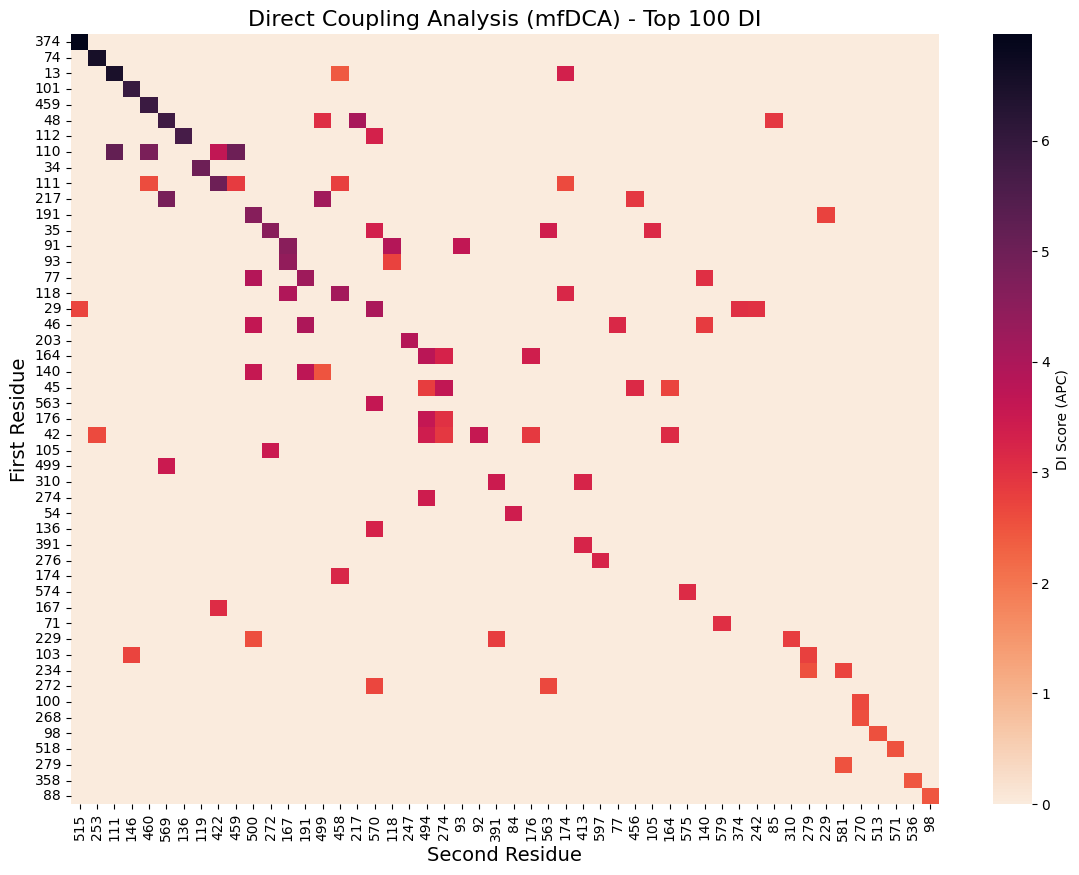

In [55]:
plt.figure(figsize=(14, 10))
plt.title('Direct Coupling Analysis (mfDCA) - Top 100 DI', size=16)
sns.heatmap(correlation_matrix, cmap='rocket_r', cbar_kws={'label': 'DI Score (APC)'})
plt.ylabel("First Residue", size=14)
plt.xlabel("Second Residue", size=14)
plt.savefig('results/alphavirus/mfdca_heatmap_nsp4_compact.png')
plt.show()

## Extended structure with cisPro103 modification

In [3]:
import ast

cov = pd.read_csv('results/alphavirus/DCA/mfdca_output_nsp4-RdRp_cisPro103.fastaTrimmed_alphavirus_rvdb_nsp4_concat_aligned.fa.csv')
print(cov['APC'].mean(axis=0))

cov['Zscore'] = Zscore(cov['APC'])
# converts tuple os string into a tuple of integers
cov['Tuple'] = [ast.literal_eval(i) for i in cov['Tuple']]
cov.head()

0.00013994277478664087


,first_site,second_site,Tuple,APC,Zscore
0,13,111,"(13, 111)",11.737895,62.841064
1,162,488,"(162, 488)",9.252337,49.533993
2,488,603,"(488, 603)",9.093311,48.682611
3,162,603,"(162, 603)",8.601993,46.052215
4,155,610,"(155, 610)",8.549699,45.772245


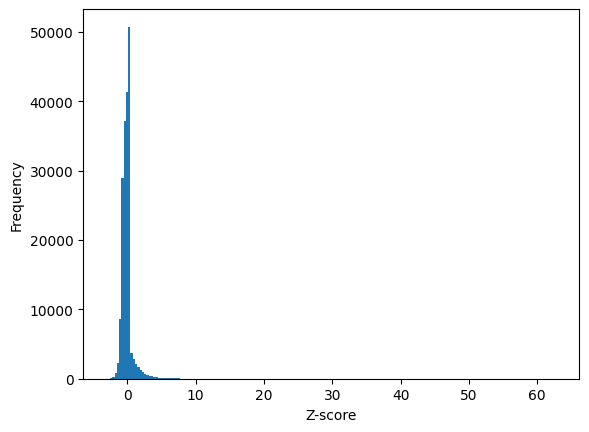

In [4]:
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
#plt.savefig('results/alphavirus/DCA/mfdca_nsp4_cisPro103_Zscore_hist.png')
plt.show()

In [5]:
cov_cisPro103_Nter = cov.query("first_site <100 or second_site < 100")
cov_cisPro103_Nter

,first_site,second_site,Tuple,APC,Zscore
0,13,111,"(13, 111)",11.737895,62.841064
5,74,253,"(74, 253)",8.466822,45.328542
7,85,412,"(85, 412)",7.182775,38.454067
8,30,586,"(30, 586)",6.947125,37.192455
12,54,84,"(54, 84)",5.868021,31.415195
...,...,...,...,...,...
186349,84,249,"(84, 249)",-0.528723,-2.831401
186350,84,594,"(84, 594)",-0.543929,-2.912810
186351,48,593,"(48, 593)",-0.550202,-2.946398
186352,84,593,"(84, 593)",-0.558397,-2.990272


In [6]:
neff = pd.read_excel('results/alphavirus/nsp4_alphavirus_urvdb_Full_Neff_.xlsx', index_col=0)

df1 = cov_cisPro103_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_cisPro103_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]]

#cov_cisPro103_Nter_neff.query("Zscore > 3.0 & first_site_Neff > 3 & second_site_Neff > 3")
#cov_cisPro103_Nter_neff = cov_cisPro103_Nter_neff.query("APC > 1.0 & first_site_Neff > 3 & second_site_Neff > 3")
cov_cisPro103_Nter_neff = cov_cisPro103_Nter_neff.query("Zscore > 2.0")
cov_cisPro103_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",11.737895,62.841064
1,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",8.466822,45.328542
2,ARG,85,3.290797,SER,412,2.120664,"(85, 412)",7.182775,38.454067
3,VAL,30,5.015656,MET,586,1.951479,"(30, 586)",6.947125,37.192455
4,GLU,54,3.197175,CYS,84,4.192845,"(54, 84)",5.868021,31.415195
...,...,...,...,...,...,...,...,...,...
2120,VAL,17,1.701981,LEU,334,1.000000,"(17, 334)",0.374483,2.004142
2121,THR,20,4.804889,ILE,26,3.877464,"(20, 26)",0.374264,2.002966
2122,CYS,84,4.192845,HIS,179,3.069596,"(84, 179)",0.374130,2.002254
2123,GLU,45,1.000000,LEU,536,1.173269,"(45, 536)",0.373847,2.000734


### Adding diatances

In [ ]:
cov_cisPro103_Nter_neff['Tuple'] = cov_cisPro103_Nter_neff['Tuple'].astype(str)

In [7]:
cisPro103_contact = pd.read_table('data/alphavirus/nsP4_pdb/nsp4-RdRp_cisPro103_pairs_contact.txt')
cisPro103_contact 

,Contact,Residue1_Name,Residue1_Pos,Residue2_Name,Residue2_Pos,Pairs,Distance(Å)
0,1,TYR,1,TYR,1,"(1, 1)",0.00
1,2,TYR,1,ILE,2,"(1, 2)",3.82
2,3,TYR,1,PHE,3,"(1, 3)",6.01
3,4,TYR,1,SER,4,"(1, 4)",6.43
4,5,TYR,1,SER,5,"(1, 5)",6.35
...,...,...,...,...,...,...,...
61095,61096,ILE,100,TYR,607,"(100, 607)",54.68
61096,61097,ILE,100,GLY,608,"(100, 608)",56.86
61097,61098,ILE,100,GLY,609,"(100, 609)",54.28
61098,61099,ILE,100,PRO,610,"(100, 610)",54.39


In [20]:
cols=['Contact', 'Residue1_Name', 'Residue1_Pos', 'Residue2_Name', 'Residue2_Pos', 'Pairs',]
df = cov_cisPro103_Nter_neff.merge(cisPro103_contact , left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,GLN,13,1.144242,ILE,111,3.552320,"(13, 111)",11.737895,62.841064,39.46
1,ALA,74,1.158375,LEU,253,2.789005,"(74, 253)",8.466822,45.328542,25.23
2,ARG,85,3.290797,SER,412,2.120664,"(85, 412)",7.182775,38.454067,46.49
3,VAL,30,5.015656,MET,586,1.951479,"(30, 586)",6.947125,37.192455,50.09
4,GLU,54,3.197175,CYS,84,4.192845,"(54, 84)",5.868021,31.415195,26.32
...,...,...,...,...,...,...,...,...,...,...
2120,VAL,17,1.701981,LEU,334,1.000000,"(17, 334)",0.374483,2.004142,19.30
2121,THR,20,4.804889,ILE,26,3.877464,"(20, 26)",0.374264,2.002966,7.38
2122,CYS,84,4.192845,HIS,179,3.069596,"(84, 179)",0.374130,2.002254,62.18
2123,GLU,45,1.000000,LEU,536,1.173269,"(45, 536)",0.373847,2.000734,60.24


In [21]:
df1= df[df['first_site'].between(20, 90) | df['second_site'].between(20, 90) ]
df2 = df1[abs(df1['first_site'] -  df1['second_site']) >= 4] 
df2 = df2.query('`Distance(Å)` < 10')
df2

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
9,CYS,84,4.192845,LEU,253,2.789005,"(84, 253)",3.880184,20.772802,8.81
38,SER,57,1.989130,ASN,234,1.581915,"(57, 234)",2.782460,14.895860,9.24
83,GLU,42,4.303649,CYS,84,4.192845,"(42, 84)",1.939891,10.384949,7.07
128,ALA,89,5.446181,ALA,270,1.224950,"(89, 270)",1.500820,8.034275,7.99
135,CYS,84,4.192845,ALA,89,5.446181,"(84, 89)",1.476524,7.904198,9.43
227,LEU,88,2.009596,ALA,270,1.224950,"(88, 270)",1.168133,6.253147,7.62
363,LYS,34,3.089355,THR,249,1.208906,"(34, 249)",0.955657,5.115602,9.37
545,ILE,77,3.586551,LYS,81,3.360074,"(77, 81)",0.799003,4.276917,9.04
606,ARG,51,1.761330,ASN,60,1.000000,"(51, 60)",0.760869,4.072759,9.40
650,GLU,42,4.303649,ALA,242,2.673552,"(42, 242)",0.729754,3.906176,9.98


### Adding rASA

In [24]:
cisPro103_rASA = pd.read_excel('results/alphavirus/rASA/nsp4_rASA_cisPro103.xlsx', index_col=0)
cisPro103_rASA

,Residue,position,rASA
0,Y,1,0.399240
1,I,2,0.857868
2,F,3,0.404167
3,S,4,0.129032
4,S,5,0.083871
...,...,...,...
606,Y,607,0.076046
607,G,608,0.471154
608,G,609,0.009615
609,P,610,0.584906


In [25]:
mapping = {k:v for k, v in zip(cisPro103_rASA['position'], cisPro103_rASA['rASA'])}

In [26]:
df2['first_site_rASA'] = [mapping[x] for x in df2['first_site']]
df2['second_site_rASA'] = [mapping[x] for x in df2['second_site']]


cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_rASA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_rASA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ]

df2 = df2[cols]
df2

,first_site_residue,first_site,first_site_Neff,first_site_rASA,second_site_residue,second_site,second_site_Neff,second_site_rASA,Tuple,APC,Zscore,Distance(Å)
9,CYS,84,4.192845,0.071856,LEU,253,2.789005,0.497512,"(84, 253)",3.880184,20.772802,8.81
38,SER,57,1.989130,0.045161,ASN,234,1.581915,0.066667,"(57, 234)",2.782460,14.895860,9.24
83,GLU,42,4.303649,0.026906,CYS,84,4.192845,0.071856,"(42, 84)",1.939891,10.384949,7.07
128,ALA,89,5.446181,0.271318,ALA,270,1.224950,0.201550,"(89, 270)",1.500820,8.034275,7.99
135,CYS,84,4.192845,0.071856,ALA,89,5.446181,0.271318,"(84, 89)",1.476524,7.904198,9.43
227,LEU,88,2.009596,0.353234,ALA,270,1.224950,0.201550,"(88, 270)",1.168133,6.253147,7.62
363,LYS,34,3.089355,0.334746,THR,249,1.208906,0.360465,"(34, 249)",0.955657,5.115602,9.37
545,ILE,77,3.586551,0.527919,LYS,81,3.360074,0.224576,"(77, 81)",0.799003,4.276917,9.04
606,ARG,51,1.761330,0.047445,ASN,60,1.000000,0.010256,"(51, 60)",0.760869,4.072759,9.40
650,GLU,42,4.303649,0.026906,ALA,242,2.673552,0.085271,"(42, 242)",0.729754,3.906176,9.98


In [27]:
#df2 = pd.read_excel('results/alphavirus/DCA/nsp4_extended_contact_pairs_neff_APC_Zscore_rASA_Nter_20_90_v02.xlsx')
df2['first_site'] = df2['first_site_residue'].astype(str) + '-' + df2['first_site'].astype(str)
df2['second_site'] = df2['second_site_residue'].astype(str) + '-' + df2['second_site'].astype(str)
df2.drop(['first_site_residue', 'second_site_residue'], axis=1, inplace=True)
df2

,first_site,first_site_Neff,first_site_rASA,second_site,second_site_Neff,second_site_rASA,Tuple,APC,Zscore,Distance(Å)
9,CYS-84,4.192845,0.071856,LEU-253,2.789005,0.497512,"(84, 253)",3.880184,20.772802,8.81
38,SER-57,1.989130,0.045161,ASN-234,1.581915,0.066667,"(57, 234)",2.782460,14.895860,9.24
83,GLU-42,4.303649,0.026906,CYS-84,4.192845,0.071856,"(42, 84)",1.939891,10.384949,7.07
128,ALA-89,5.446181,0.271318,ALA-270,1.224950,0.201550,"(89, 270)",1.500820,8.034275,7.99
135,CYS-84,4.192845,0.071856,ALA-89,5.446181,0.271318,"(84, 89)",1.476524,7.904198,9.43
227,LEU-88,2.009596,0.353234,ALA-270,1.224950,0.201550,"(88, 270)",1.168133,6.253147,7.62
363,LYS-34,3.089355,0.334746,THR-249,1.208906,0.360465,"(34, 249)",0.955657,5.115602,9.37
545,ILE-77,3.586551,0.527919,LYS-81,3.360074,0.224576,"(77, 81)",0.799003,4.276917,9.04
606,ARG-51,1.761330,0.047445,ASN-60,1.000000,0.010256,"(51, 60)",0.760869,4.072759,9.40
650,GLU-42,4.303649,0.026906,ALA-242,2.673552,0.085271,"(42, 242)",0.729754,3.906176,9.98


In [28]:
#df2.to_excel('results/alphavirus/DCA/nsp4_cisPro103_contact_pairs_neff_APC_Zscore_rASA_Nter_20_90_v02.xlsx')

In [31]:
#df2['Tuple'].values
[ast.literal_eval(i) for i in df2['Tuple']]

[(84, 253),
 (57, 234),
 (42, 84),
 (89, 270),
 (84, 89),
 (88, 270),
 (34, 249),
 (77, 81),
 (51, 60),
 (42, 242),
 (51, 55),
 (42, 79),
 (55, 60),
 (64, 241),
 (24, 238),
 (25, 94),
 (20, 25),
 (35, 39),
 (41, 80),
 (36, 247),
 (43, 243),
 (42, 243),
 (24, 335),
 (46, 268),
 (46, 64),
 (5, 58),
 (25, 93),
 (21, 94),
 (20, 26)]

In [ ]:
(84, 253), (57, 234), (42, 84), (89, 270), (84, 89), (88, 270), (34, 249), (77, 81), (51, 60), (42, 242), (51, 55), (42, 79), (55, 60), (64, 241), (24, 238), (25, 94), (20, 25), (35, 39), (41, 80), (36, 247), (43, 243), (42, 243), (24, 335), (46, 268), (46, 64), (5, 58), (25, 93), (21, 94), (20, 26)